# 521153S, Deep Learning Final Project: Mini Image classification Competition with CNN

#### Download the given dataset

In [1]:
# import necessary packages
import os, time
import torch 
import requests, zipfile, sys
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from utils import download_given_data, get_preds_figure
import torchvision
from PIL import Image, ImageOps, ImageFilter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils
import random, matplotlib
import pandas as pd
from torchvision.models.resnet import BasicBlock, Bottleneck
from torch.utils.tensorboard import SummaryWriter

download_given_data('./')

Data was already downloaded and extracted!


In [2]:
# Check if GPU is available
print("GPU_available={}".format(torch.cuda.is_available()))

if(torch.cuda.is_available()):
    torch.cuda.set_device(0)

GPU_available=True


### Custom dataset class for this project

In [3]:
# Dataset class
# Takes a csv file. Transforms to perform data augmentation.
class ProjectDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        # Read the csv file
        self.frame = pd.read_csv(csv_file, header=None)
        self.transform = transform
        
        self.label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship']

    def __getitem__(self, idx):
        image_name = self.frame.iloc[idx, 0]
        image = Image.open(image_name)
        
        label = self.frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'label': label}

        return sample

    def __len__(self):
        return len(self.frame)

### Print some information from the datasets

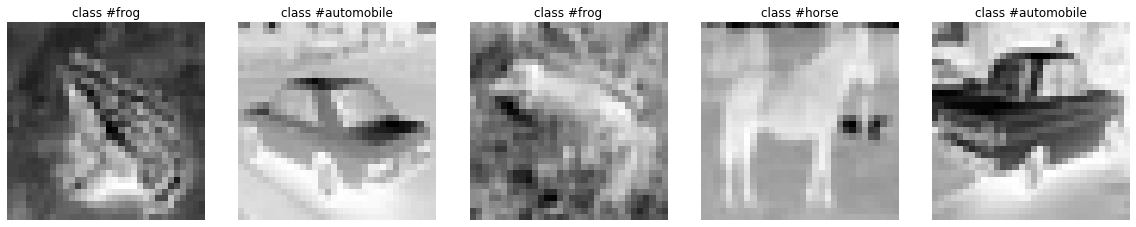

total number of images in training set: 36000
number of images for class airplane: 4000
number of images for class automobile: 4000
number of images for class bird: 4000
number of images for class cat: 4000
number of images for class deer: 4000
number of images for class dog: 4000
number of images for class frog: 4000
number of images for class horse: 4000
number of images for class ship: 4000


In [4]:
# Create a train_set from the train.csv file without any transformations
train_set = ProjectDataset(csv_file='./given_data/train.csv', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(train_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = train_set[idx[i]]['image'], train_set[idx[i]]['label']
    label_name = train_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)

plt.show()

# Print the number of total images in the training set
print('total number of images in training set: {}'.format(len(train_set)))

# Print the number of images per class in the training set
class_num_train = np.zeros(9, dtype=np.int32)
for x in train_set:
    class_num_train[x['label']] += 1
for i in range(9):
    print('number of images for class {}: {}'.format(train_set.label_names[i], class_num_train[i]))

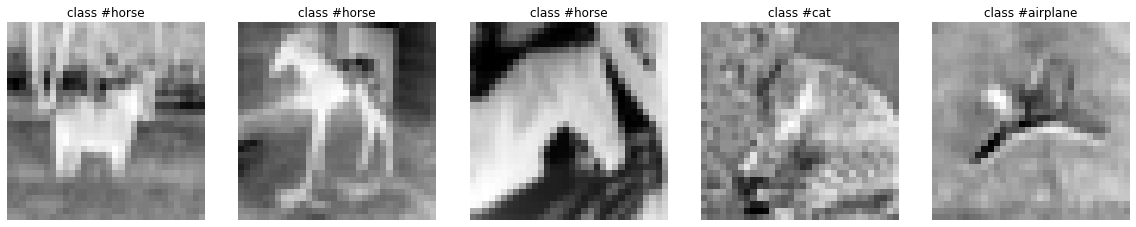

total number of images in validation set: 9000
number of images for class airplane: 1000
number of images for class automobile: 1000
number of images for class bird: 1000
number of images for class cat: 1000
number of images for class deer: 1000
number of images for class dog: 1000
number of images for class frog: 1000
number of images for class horse: 1000
number of images for class ship: 1000


In [5]:
# Create a valid_set from the val.csv file without any transformations
valid_set = ProjectDataset(csv_file='./given_data/val.csv', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(valid_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = valid_set[idx[i]]['image'], valid_set[idx[i]]['label']
    label_name = valid_set.label_names[label]
    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)
    
plt.show()

# Print the number of total images in the validation set 
print('total number of images in validation set: {}'.format(len(valid_set)))   

# Print the number of images per class in the validation set
class_num_valid = np.zeros(9, dtype=np.int32)
for x in valid_set:
    class_num_valid[x['label']] += 1
for i in range(9):
    print('number of images for class {}: {}'.format(valid_set.label_names[i], class_num_valid[i]))

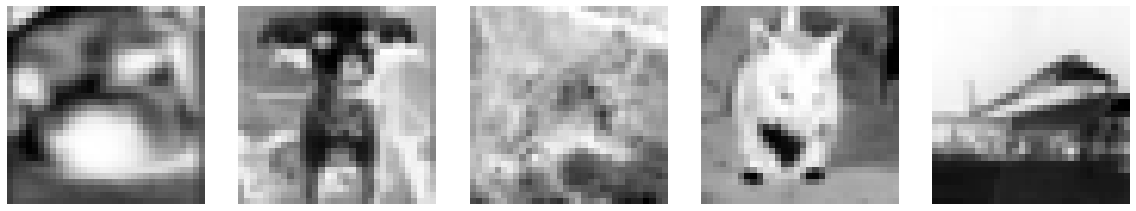

total number of images in testing set: 9000


In [6]:
# Create a test_set from the test.csv file without any transformations
test_set = ProjectDataset(csv_file='./test.csv', transform=None)
num_to_show = 5
idx = np.random.choice(range(len(test_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = test_set[idx[i]]['image'], test_set[idx[i]]['label']
    label_name = test_set.label_names[label]
    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.axis('off')
    plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)

plt.show()

# Print the number of total images in the testing set    
print('total number of images in testing set: {}'.format(len(test_set)))   

### Data Augmentation
Class for custom data transformation:
* 50% chance to drop a square window to a random location
* 80% chance to make a random affine transformation (5-degree rotation both ways, 15% scaling up or down, 7-degree shear both ways)

In addition:
* 50% chance to crop image to 36 pixels
* 50% chance to flip image horizontally

In [71]:
# Define a custom data transformation for data augmentation.
# There is 80% chance that it will apply random affine transformation.
# There is 50% chance that it will randomly cut a square window inside image.
# There is 50% chance to horizontally flip the image.
# There is 50% chance to randomly crop the image to 30x30 pixels.
class CustomDataAugmentation(object):
    def __init__(self, window_size):
        assert isinstance(window_size, (int, tuple))
        if isinstance(window_size, int):
            self.window_size = (window_size, window_size)
        else:
            assert len(window_size) == 2
            self.window_size = window_size
        
        # Define random affine transformation attributes
        self.trans = transforms.RandomAffine(degrees=(-5,5), scale=(0.85,1.15), shear=(-7,7), fillcolor=0)
        
        # Define a horizontal flip
        self.flip = transforms.RandomHorizontalFlip(p=1.0)
        
        # Define a random crop
        self.crop = transforms.RandomCrop(36, pad_if_needed=True, fill=0, padding_mode='edge')

    def __call__(self, sample):
        image = sample
        
        # Random Crop
        if random.random() < 0.5:
            image = self.crop(image)

        # RandomWindowDrop
        if random.random() < 0.5:
            h, w = image.size
            imagePixels = image.load()
            top = np.random.randint(self.window_size[0], h - self.window_size[0])
            left = np.random.randint(self.window_size[1], w - self.window_size[1])
            for i in range(top, top+self.window_size[0], 1):
                for j in range(left, left+self.window_size[1], 1):   
                    imagePixels[i, j] = 0
        
        # Random Affine Transformation
        if random.random() < 0.8:
            image = self.trans(image)
        
        # Random Horizontal Flip
        if random.random() < 0.5:
            image = self.flip(image)
        
        return image

### Define functions for loading training/validation/testing data to DataLoader

Training data:
* Apply data augmentation
* Shuffle

Validation data:
* Don't shuffle

Testing data:
* Don't shuffle

All data is resized to 224 to fit the CNN and normalized.

In [72]:
# Load the training/validation/testing data to Dataloader
def getTrainingData(csv_file='', batch_size=32, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}
    transformed_training = ProjectDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            CustomDataAugmentation(6),
                                            transforms.Resize(224, interpolation=2),
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))

    dataloader_training = DataLoader(transformed_training, batch_size, shuffle=True, num_workers=num_workers)

    return dataloader_training

def getEvalData(csv_file='', batch_size=32, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}
    transformed_eval = ProjectDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            transforms.Resize(224, interpolation=2),
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))
    
    dataloader_eval = DataLoader(transformed_eval, batch_size, shuffle=False, num_workers=num_workers)

    return dataloader_eval

def getTestData(csv_file='', batch_size=32, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}
    transformed_test = ProjectDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            transforms.Resize(224, interpolation=2),
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))
    
    dataloader_test = DataLoader(transformed_test, batch_size, shuffle=False, num_workers=num_workers)

    return dataloader_test

### Create loaders for training/valid/test data
Using batch size of 32.

In [73]:
# Create train_loader with shuffling, batch_size = 32
train_loader = getTrainingData(csv_file='./given_data/train.csv', batch_size=32, num_workers=0)

# Create valid_loader with no shuffling, batch_size = 32
valid_loader = getEvalData(csv_file='./given_data/val.csv', batch_size=32, num_workers=0)

# Create test_loader with no shuffling, batch_size = 32
test_loader = getTestData(csv_file='./test.csv', batch_size=32, num_workers=0)

### Custom ResNet-50 class
First convolutional layer needs to be modified to accept greyscale images.

In [64]:
# ResNet-50 CNN model
class ResNet50_Project(torchvision.models.ResNet):
    def __init__(self, num_classes=9):
        super(ResNet50_Project, self).__init__(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)
        # Override the "conv1" layer from the ResNet-50 model
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).cuda()

    def forward(self, x):
        return super(ResNet50_Project, self).forward(x.cuda())

### Instantiate ResNet-50 model
Print out example grid of images in the network.

ResNet50_Project(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

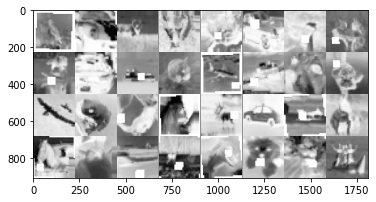

In [70]:
# Create a train writer and a validation writer
# tensorboard --logdir tb_graphs/ --port 5656
writer = SummaryWriter('tb_graphs/training')
val_writer = SummaryWriter('tb_graphs/validation')

# Instantiate ResNet-50 network model
net = ResNet50_Project(num_classes=9)
net.cuda()

# Print out the layers of our model
print(net)

# Get some random training images
_iter = iter(train_loader)
samples = _iter.next()
images = samples['image']

# Create grid of images
img_grid = torchvision.utils.make_grid(images)

# Show images
plt.imshow(img_grid.mean(dim=0).cpu().numpy(), cmap="Greys")

# Write to tensorboard
writer.add_image('train_images', img_grid)

# Write model graph to tensorboard
writer.add_graph(net, images)

### Training, evaluation and save function
Training happens using the SGD function using following values:
* Momentum = 0.9
* Learning rate = 0.01
* Weight decay = 0.001
* Epochs = 10

Every 200 iterations are logged to tensorboard as well as the final evaluation against the validation set at the end of the epoch

In [74]:
# Save predicted labels to text file
def save_predictions(net, data_loader):
    net.eval()
    with open("./labels.txt", 'w') as f:
        f.truncate(0) # clear old labels
        for i, sample in enumerate(data_loader):
            images = sample['image']
            outs = net(images)
            _, preds = outs.max(1)
            predictions = preds.data.cpu().tolist()
            if predictions:
                for i in predictions:
                    f.write(str(i) + '\n') # Manually remove the last empty line to have exactly 9000 lines

    print("Labels saved!")

# Evaluation function
def eval(net, loss_function, data_loader):
    net.eval()
    correct = 0.0
    num_images = 0.0
    running_loss = 0.0
    for i, sample in enumerate(data_loader):
        images, labels = sample['image'], sample['label']
        outs = net(images)
        _, preds = outs.max(1)
        correct += preds.eq(labels.cuda()).sum()
        running_loss += loss_function(outs.cuda(), labels.cuda()).item()
        num_images += len(labels)

    acc = correct.float() / num_images
    loss = running_loss / len(data_loader)
    return acc, loss

# Training function
def train(net, train_loader, valid_loader, writer, val_writer, loss_function):
    # SGD optimizer parameters
    learning_rate = 0.01
    weight_decay = 0.001
    momentum = 0.9
    
    # SGD optimizer
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Log training process to tensorboard every 200 iterations
    log_every = 200
    
    # Training for 10 epochs
    epoches = 10
    for epoch in range(epoches):
        start_t = time.time()
        net.train() 
        running_loss = 0.0
        running_acc = 0.0
        for i, sample in enumerate(train_loader):      
            images, labels = sample['image'], sample['label']
            outs = net(images)
            loss = loss_function(outs.cuda(), labels.cuda()) 
            _, preds = outs.max(1)
            correct = preds.eq(labels.cuda()).sum()
            running_acc += correct.float() / len(labels)
            
            # clear grads, backward propagation, update parameters
            net.zero_grad()
            loss.backward()
            with torch.no_grad():
                for param in net.parameters():
                    param -= learning_rate * param.grad
                        
            running_loss += loss.item()
            
            if i % log_every == 199: 
                
                print('[Epoch/iter]: [{}/{}], loss: {:.05f}, accuracy: {:.05f}'.format(epoch, i+1, 
                           running_loss / log_every, running_acc / log_every))

                log_index = epoch * len(train_loader) + i
                # Log the training loss and accuracy
                writer.add_scalar('Loss', running_loss / log_every, log_index)
                
                # load the training accuracy using writer
                writer.add_scalar('Accuracy', running_acc / log_every, log_index)

                # Log predictions
                writer.add_figure('predictions', get_preds_figure(net, images, labels), log_index)
                running_loss = 0.0
                running_acc = 0.0
        
        # Running the validation
        acc_eval, loss_eval = eval(net, loss_function, valid_loader)
        print('Elapsed time: {:.02f} seconds, end of epoch: {}, lr: {}, val_loss: {:.05f}, val_acc: {:.05f}'.format(
            time.time()-start_t, epoch, optimizer.param_groups[0]['lr'], loss_eval, acc_eval))
        
        # Log the validation loss and accuracy
        val_writer.add_scalar('Loss', loss_eval, log_index)
        
        # Load the validation accuracy using val_writer
        val_writer.add_scalar('Accuracy', acc_eval, log_index)

    return net

### Train and test the network
Save the weights of current models to disk.
Save the the predicted labels of test data to a text file.

NOTE: You have to manually remove the last line from the text file if you want exactly 9000 lines.

In [69]:
# Load the model weights from './net.pth'
if (torch.load('./net.pth')):
    net.load_state_dict(torch.load('./net.pth'))

# Train and test the network
print('Please wait patiently, it may take some seconds...')

# Train network
loss_function = torch.nn.CrossEntropyLoss().cuda()
net_trained = train(net, train_loader, valid_loader, writer, val_writer, loss_function)

# Save the weight of current model to disk
PATH = './net.pth'
torch.save(net.state_dict(), PATH)

# Save predicted labels on test data to a text file
save_predictions(net_trained, test_loader)

# Close the training and validation writer
writer.close()
val_writer.close()

Please wait patiently, it may take some seconds...
[Epoch/iter]: [0/200], loss: 0.42405, accuracy: 0.85219
[Epoch/iter]: [0/400], loss: 0.43702, accuracy: 0.85156
[Epoch/iter]: [0/600], loss: 0.44080, accuracy: 0.84766
[Epoch/iter]: [0/800], loss: 0.44541, accuracy: 0.84766
[Epoch/iter]: [0/1000], loss: 0.44073, accuracy: 0.84859
Elapsed time: 279.53 seconds, end of epoch: 0, lr: 0.01, val_loss: 0.54657, val_acc: 0.82233
[Epoch/iter]: [1/200], loss: 0.41619, accuracy: 0.85578
[Epoch/iter]: [1/400], loss: 0.43057, accuracy: 0.84891
[Epoch/iter]: [1/600], loss: 0.41589, accuracy: 0.85234
[Epoch/iter]: [1/800], loss: 0.42654, accuracy: 0.85156
[Epoch/iter]: [1/1000], loss: 0.41544, accuracy: 0.84984
Elapsed time: 280.85 seconds, end of epoch: 1, lr: 0.01, val_loss: 0.53649, val_acc: 0.82722
[Epoch/iter]: [2/200], loss: 0.39827, accuracy: 0.85641
[Epoch/iter]: [2/400], loss: 0.39834, accuracy: 0.86000
[Epoch/iter]: [2/600], loss: 0.43233, accuracy: 0.84844
[Epoch/iter]: [2/800], loss: 0.39